# Environment Setup and GPU Activation

In [1]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'}")

# Install required packages
# !pip install transformers datasets accelerate evaluate scikit-learn wandb -q

# Import essential libraries
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


CUDA available: True
GPU device: Tesla T4


# Data Loading and Exploration

In [2]:
# Load IMDb dataset (well-structured for learning)
print("Loading IMDb dataset...")
dataset = load_dataset("imdb")

# Explore the dataset structure
print(f"Dataset structure: {dataset}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

# Sample data exploration
sample_data = dataset['train'][:5]
for i, (text, label) in enumerate(zip(sample_data['text'], sample_data['label'])):
    print(f"\nSample {i+1}:")
    print(f"Label: {'Positive' if label == 1 else 'Negative'}")
    print(f"Text (first 100 chars): {text[:100]}...")

# Analyze label distribution
train_labels = dataset['train']['label']
label_counts = Counter(train_labels)
print(f"\nLabel distribution: {label_counts}")


Loading IMDb dataset...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
Training samples: 25000
Test samples: 25000

Sample 1:
Label: Negative
Text (first 100 chars): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...

Sample 2:
Label: Negative
Text (first 100 chars): "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's poli...

Sample 3:
Label: Negative
Text (first 100 chars): If only to avoid making this type of film in the future. This film is interesting as an experiment b...

Sample 4:
Label: Negative
Text (first 100 chars): This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instea...

Sample 5:
Label: Negative


# Data Preprocessing and Text Handling

In [3]:
# Create a subset for faster training (important for Colab free tier)
def create_subset(dataset, size=10000):
    """Create balanced subset for efficient training"""
    # Get equal samples from each class
    positive_samples = [i for i, label in enumerate(dataset['label']) if label == 1][:size//2]
    negative_samples = [i for i, label in enumerate(dataset['label']) if label == 0][:size//2]

    selected_indices = positive_samples + negative_samples

    subset = {
        'text': [dataset['text'][i] for i in selected_indices],
        'label': [dataset['label'][i] for i in selected_indices]
    }

    return Dataset.from_dict(subset)

# Create training and validation subsets
train_dataset = create_subset(dataset['train'], 10000)
val_dataset = create_subset(dataset['test'], 2000)

print(f"Training subset size: {len(train_dataset)}")
print(f"Validation subset size: {len(val_dataset)}")

# Text preprocessing functions
def preprocess_text(text):
    """Basic text cleaning and normalization"""
    # Remove HTML tags
    import re
    text = re.sub(r'<[^>]+>', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Convert to lowercase (optional for BERT)
    return text.lower()

# Apply preprocessing
train_dataset = train_dataset.map(lambda x: {'text': preprocess_text(x['text'])})
val_dataset = val_dataset.map(lambda x: {'text': preprocess_text(x['text'])})


Training subset size: 10000
Validation subset size: 2000


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Tokenization and Data Preparation

In [4]:
# Initialize tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Analyze text lengths for optimal max_length setting
def analyze_text_lengths(dataset):
    """Analyze text lengths to optimize tokenization"""
    lengths = []
    for text in dataset['text']:
        tokens = tokenizer.tokenize(text)
        lengths.append(len(tokens))

    print(f"Text length statistics:")
    print(f"Mean: {np.mean(lengths):.2f}")
    print(f"Median: {np.median(lengths):.2f}")
    print(f"95th percentile: {np.percentile(lengths, 95):.2f}")
    print(f"99th percentile: {np.percentile(lengths, 99):.2f}")

    return lengths

lengths = analyze_text_lengths(train_dataset)

# Tokenization function
def tokenize_function(examples):
    """Tokenize text with optimal parameters"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=256,  # Based on length analysis
        return_tensors="pt"
    )

# Apply tokenization
print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


Text length statistics:
Mean: 296.00
Median: 219.00
95th percentile: 764.05
99th percentile: 1175.00
Tokenizing datasets...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Model Setup and Configuration

In [5]:
# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "Negative", 1: "Positive"},
    label2id={"Negative": 0, "Positive": 1}
)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Data collator for efficient batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define metrics computation
def compute_metrics(eval_pred):
    """Compute comprehensive evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Configuration and Optimization

In [7]:
# Training arguments optimized for Colab free tier
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,      # Optimized for T4 GPU
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    warmup_steps=500,
    fp16=True,                          # Mixed precision for speed
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to="none"                    # Disable wandb for simplicity
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Display training setup
print("Training Configuration:")
print(f"Model: {model_name}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Epochs: {training_args.num_train_epochs}")

Training Configuration:
Model: bert-base-uncased
Training samples: 10000
Validation samples: 2000
Batch size: 8
Learning rate: 2e-05
Epochs: 3


# Model Training with Progress Monitoring

In [9]:
# Start training
print("Starting training...")
import time
start_time = time.time()

# Train the model
trainer.train()

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")

# Save the model
trainer.save_model("./sentiment-bert-model")
print("Model saved successfully!")

Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.407200,0.291952,0.889500,0.889458,0.890093,0.889500
1000,0.308400,0.288067,0.893500,0.893459,0.894099,0.893500
1500,0.214400,0.364206,0.903000,0.902986,0.903232,0.903000
2000,0.176300,0.400404,0.901500,0.901389,0.903310,0.901500
2500,0.189400,0.375435,0.906500,0.906500,0.906500,0.906500
3000,0.124700,0.480485,0.905000,0.904995,0.905079,0.905000
3500,0.104400,0.486771,0.901500,0.901494,0.901590,0.901500



Training completed in 12.78 minutes
Model saved successfully!


# Comprehensive Model Evaluation

Evaluating model...



Evaluation Results:
eval_loss: 0.3754
eval_accuracy: 0.9065
eval_f1: 0.9065
eval_precision: 0.9065
eval_recall: 0.9065
eval_runtime: 7.7279
eval_samples_per_second: 258.8040
eval_steps_per_second: 32.3510
epoch: 3.0000

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.91      0.91      1000
    Positive       0.91      0.91      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



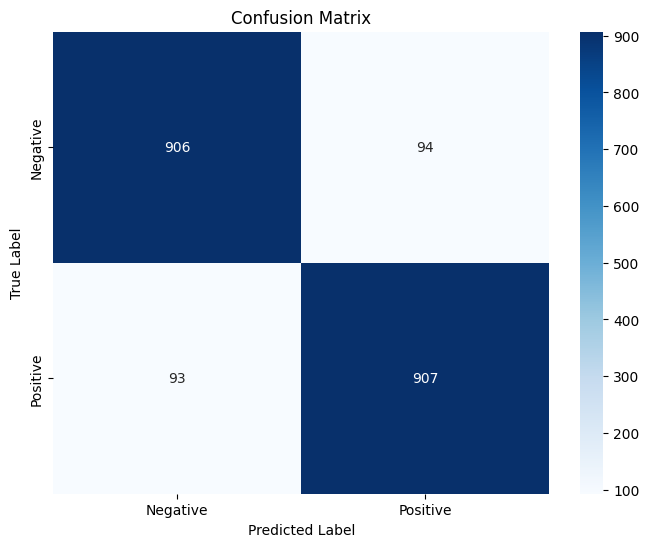

In [10]:
# Evaluate on validation set
print("Evaluating model...")
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Detailed predictions analysis
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(true_labels, predicted_labels,
                          target_names=['Negative', 'Positive']))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Model Testing and Debugging

In [11]:
# Test with custom examples
def predict_sentiment(text, model, tokenizer, device):
    """Predict sentiment for custom text"""
    # Preprocess text
    text = preprocess_text(text)

    # Tokenize
    inputs = tokenizer(text, return_tensors="pt",
                      truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1)

    sentiment = "Positive" if prediction.item() == 1 else "Negative"
    confidence = probabilities.max().item()

    return sentiment, confidence, probabilities[0].cpu().numpy()

# Test examples
test_examples = [
    "This movie is absolutely amazing! I loved every minute of it.",
    "Terrible movie, waste of time. Very disappointed.",
    "The movie was okay, not great but not terrible either.",
    "Outstanding performance by the actors, brilliant storytelling!",
    "Boring and predictable plot. Couldn't wait for it to end."
]

print("Testing model with custom examples:")
print("-" * 50)
for text in test_examples:
    sentiment, confidence, probs = predict_sentiment(text, model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.3f})")
    print(f"Probabilities: Negative={probs[0]:.3f}, Positive={probs[1]:.3f}")
    print("-" * 50)


Testing model with custom examples:
--------------------------------------------------
Text: This movie is absolutely amazing! I loved every minute of it.
Prediction: Positive (Confidence: 0.998)
Probabilities: Negative=0.002, Positive=0.998
--------------------------------------------------
Text: Terrible movie, waste of time. Very disappointed.
Prediction: Negative (Confidence: 0.999)
Probabilities: Negative=0.999, Positive=0.001
--------------------------------------------------
Text: The movie was okay, not great but not terrible either.
Prediction: Positive (Confidence: 0.899)
Probabilities: Negative=0.101, Positive=0.899
--------------------------------------------------
Text: Outstanding performance by the actors, brilliant storytelling!
Prediction: Positive (Confidence: 0.998)
Probabilities: Negative=0.002, Positive=0.998
--------------------------------------------------
Text: Boring and predictable plot. Couldn't wait for it to end.
Prediction: Negative (Confidence: 0.998)
Pr

# Performance Optimization and Debugging

In [12]:
# Memory usage analysis
def analyze_memory_usage():
    """Analyze GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Cached: {cached:.2f} GB")
    else:
        print("CPU training - no GPU memory analysis available")

analyze_memory_usage()

# Speed optimization techniques
def benchmark_inference_speed(model, tokenizer, test_texts, device):
    """Benchmark model inference speed"""
    import time

    model.eval()
    total_time = 0
    num_samples = len(test_texts)

    for text in test_texts:
        start_time = time.time()
        _, _, _ = predict_sentiment(text, model, tokenizer, device)
        total_time += time.time() - start_time

    avg_time = total_time / num_samples
    print(f"Average inference time: {avg_time*1000:.2f} ms per sample")
    print(f"Throughput: {1/avg_time:.2f} samples per second")

benchmark_inference_speed(model, tokenizer, test_examples, device)

# Common debugging techniques
def debug_model_outputs(model, tokenizer, problematic_text):
    """Debug model behavior on problematic inputs"""
    print(f"Debugging text: {problematic_text}")

    # Tokenize and analyze
    tokens = tokenizer.tokenize(problematic_text)
    print(f"Tokens: {tokens[:20]}...")  # Show first 20 tokens

    # Get attention weights
    inputs = tokenizer(problematic_text, return_tensors="pt",
                      truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attention_weights = outputs.attentions[-1]  # Last layer attention

    print(f"Attention shape: {attention_weights.shape}")
    print(f"Prediction logits: {outputs.logits}")
    print(f"Probabilities: {torch.softmax(outputs.logits, dim=-1)}")

# Debug a neutral sentiment example
debug_model_outputs(model, tokenizer, "The movie was okay, not great but not terrible either.")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


GPU Memory - Allocated: 1.24 GB, Cached: 2.46 GB
Average inference time: 17.42 ms per sample
Throughput: 57.41 samples per second
Debugging text: The movie was okay, not great but not terrible either.
Tokens: ['the', 'movie', 'was', 'okay', ',', 'not', 'great', 'but', 'not', 'terrible', 'either', '.']...
Attention shape: torch.Size([1, 12, 14, 14])
Prediction logits: tensor([[-1.4229,  0.7593]], device='cuda:0')
Probabilities: tensor([[0.1014, 0.8986]], device='cuda:0')


# Model Improvement Techniques

In [18]:
# Hyperparameter tuning example
def hyperparameter_sweep():
    """Demonstrate hyperparameter optimization"""
    learning_rates = [1e-5, 2e-5, 3e-5]
    batch_sizes = [8, 16]

    results = {}

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"Testing LR: {lr}, Batch Size: {bs}")

            # Create new training arguments
            training_args_test = TrainingArguments(
                output_dir=f'./results_lr{lr}_bs{bs}',
                learning_rate=lr,
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs,
                num_train_epochs=1,  # Reduced for demo
                eval_strategy="epoch",
                logging_steps=50,
                save_strategy="no",
                fp16=True
            )

            # Quick training for comparison
            trainer_test = Trainer(
                model=model,
                args=training_args_test,
                train_dataset=train_dataset.select(range(1000)),  # Small subset
                eval_dataset=val_dataset.select(range(200)),
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics
            )

            # Train and evaluate
            trainer_test.train()
            eval_result = trainer_test.evaluate()
            results[f"lr_{lr}_bs_{bs}"] = eval_result['eval_accuracy']

            print(f"Accuracy: {eval_result['eval_accuracy']:.4f}")

    return results

# Uncomment to run hyperparameter sweep
# hp_results = hyperparameter_sweep()
# print("Hyperparameter sweep results:", hp_results)

# Data Quality and Preprocessing Analysis

In [20]:
# Advanced data preprocessing techniques
def advanced_preprocessing_pipeline(dataset):
    """Demonstrate advanced preprocessing techniques"""

    # 1. Deduplication
    unique_texts = set()
    deduplicated_data = []

    for example in dataset:
        text_lower = example['text'].lower()
        if text_lower not in unique_texts:
            unique_texts.add(text_lower)
            deduplicated_data.append(example)

    print(f"Original samples: {len(dataset)}")
    print(f"After deduplication: {len(deduplicated_data)}")

    # 2. Quality filtering
    def quality_filter(text):
        """Filter low-quality text"""
        if len(text.split()) < 10:  # Too short
            return False
        if len(text) > 2000:  # Too long
            return False
        if text.count('!') > 5:  # Too many exclamations
            return False
        return True

    high_quality_data = [ex for ex in deduplicated_data if quality_filter(ex['text'])]
    print(f"After quality filtering: {len(high_quality_data)}")

    # 3. Normalization techniques
    def normalize_text(text):
        """Apply normalization techniques"""
        import re
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove excessive punctuation
        text = re.sub(r'[.!?]{2,}', '.', text)
        # Normalize whitespace
        text = ' '.join(text.split())
        return text

    normalized_data = []
    for example in high_quality_data:
        normalized_text = normalize_text(example['text'])
        normalized_data.append({'text': normalized_text, 'label': example['label']})

    return Dataset.from_list(normalized_data)

# Apply advanced preprocessing
# Use the original dataset before tokenization and formatting
processed_dataset = advanced_preprocessing_pipeline(dataset['train'])

Original samples: 25000
After deduplication: 24904
After quality filtering: 19980
